##### Copyright 2024 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API - read a PDF

This notebook demonstrates how you can convert a PDF file so that it can be read by the Gemini API.

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/PDF_Files.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Setup

In [30]:
!pip install -Uq google-generativeai

In [7]:
import google.generativeai as genai


import pathlib
import tqdm
import os

In [8]:
from google.colab import userdata
genai.configure(api_key=userdata.get("GOOGLE_API_KEY"))

Install the PDF processing tools:

In [9]:
!apt install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


## Download and proces the PDF

This textbook is from OpenStax, it's License is Commons Attribution License v4.0. More detrails are [available on the site](https://openstax.org/details/books/university-physics-volume-2).

In [10]:
import pathlib

In [11]:
if not pathlib.Path('test.pdf').exists():
    !curl -o test.pdf https://assets.openstax.org/oscms-prodcms/media/documents/UniversityPhysicsVolume2-WEB_5eNhMSa.pdf

You'll extract Chapter 3, pages [121-154].

In [12]:
first = 121
last = 154

In [13]:
!mkdir output
! # extract images of Chapter 3
!pdftoppm test.pdf -f {first} -l {last} output/images -jpeg
!ls output

mkdir: cannot create directory ‘output’: File exists
images-121.jpg	images-133.jpg	images-145.jpg	text-123.txt  text-135.txt  text-147.txt
images-122.jpg	images-134.jpg	images-146.jpg	text-124.txt  text-136.txt  text-148.txt
images-123.jpg	images-135.jpg	images-147.jpg	text-125.txt  text-137.txt  text-149.txt
images-124.jpg	images-136.jpg	images-148.jpg	text-126.txt  text-138.txt  text-150.txt
images-125.jpg	images-137.jpg	images-149.jpg	text-127.txt  text-139.txt  text-151.txt
images-126.jpg	images-138.jpg	images-150.jpg	text-128.txt  text-140.txt  text-152.txt
images-127.jpg	images-139.jpg	images-151.jpg	text-129.txt  text-141.txt  text-153.txt
images-128.jpg	images-140.jpg	images-152.jpg	text-130.txt  text-142.txt  text-154.txt
images-129.jpg	images-141.jpg	images-153.jpg	text-131.txt  text-143.txt
images-130.jpg	images-142.jpg	images-154.jpg	text-132.txt  text-144.txt
images-131.jpg	images-143.jpg	text-121.txt	text-133.txt  text-145.txt
images-132.jpg	images-144.jpg	text-122.txt	te

Look at the first image, scaled down:

In [14]:
import PIL.Image

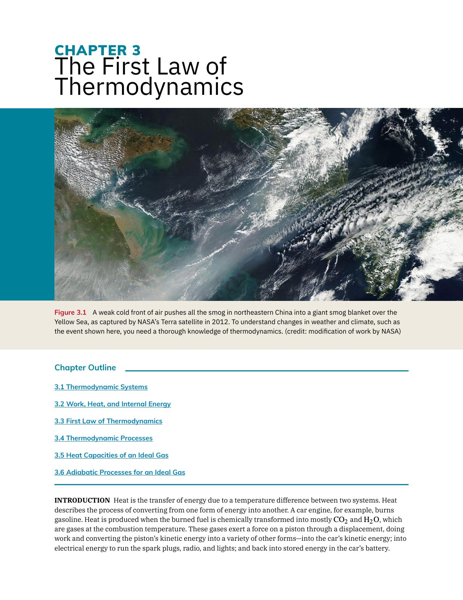

In [15]:
img = PIL.Image.open(f"output/images-{first}.jpg")
img.thumbnail([600, 600])
img

Extract the text for thopse same pages.

In [16]:
for page_number in range(first,last+1):
  page_number = f"{page_number:03d}"
  ! pdftotext  test.pdf -f {page_number} -l {page_number}
  ! mv test.txt output/text-{page_number}.txt

In [17]:
!ls output

images-121.jpg	images-133.jpg	images-145.jpg	text-123.txt  text-135.txt  text-147.txt
images-122.jpg	images-134.jpg	images-146.jpg	text-124.txt  text-136.txt  text-148.txt
images-123.jpg	images-135.jpg	images-147.jpg	text-125.txt  text-137.txt  text-149.txt
images-124.jpg	images-136.jpg	images-148.jpg	text-126.txt  text-138.txt  text-150.txt
images-125.jpg	images-137.jpg	images-149.jpg	text-127.txt  text-139.txt  text-151.txt
images-126.jpg	images-138.jpg	images-150.jpg	text-128.txt  text-140.txt  text-152.txt
images-127.jpg	images-139.jpg	images-151.jpg	text-129.txt  text-141.txt  text-153.txt
images-128.jpg	images-140.jpg	images-152.jpg	text-130.txt  text-142.txt  text-154.txt
images-129.jpg	images-141.jpg	images-153.jpg	text-131.txt  text-143.txt
images-130.jpg	images-142.jpg	images-154.jpg	text-132.txt  text-144.txt
images-131.jpg	images-143.jpg	text-121.txt	text-133.txt  text-145.txt
images-132.jpg	images-144.jpg	text-122.txt	text-134.txt  text-146.txt


In [18]:
!cat output/text-{first}.txt

CHAPTER 3

The First Law of
Thermodynamics

Figure 3.1 A weak cold front of air pushes all the smog in northeastern China into a giant smog blanket over the
Yellow Sea, as captured by NASA’s Terra satellite in 2012. To understand changes in weather and climate, such as
the event shown here, you need a thorough knowledge of thermodynamics. (credit: modification of work by NASA)

Chapter Outline
3.1 Thermodynamic Systems
3.2 Work, Heat, and Internal Energy
3.3 First Law of Thermodynamics
3.4 Thermodynamic Processes
3.5 Heat Capacities of an Ideal Gas
3.6 Adiabatic Processes for an Ideal Gas

INTRODUCTION Heat is the transfer of energy due to a temperature difference between two systems. Heat
describes the process of converting from one form of energy into another. A car engine, for example, burns
gasoline. Heat is produced when the burned fuel is chemically transformed into mostly
and
which
are gases at the combustion temperature. These gases exert a force on a piston through a displacem

## Assemble the files into a prompt

Upload all the files usng the files API, there are too many to send with the `generate_content` request.

In [19]:
files = []
image_files = list(pathlib.Path("output").glob('images-*.jpg'))
for img in tqdm.tqdm(image_files):
    files.append(genai.upload_file(img))

100%|██████████| 34/34 [00:33<00:00,  1.00it/s]


Load all the texts:

In [20]:
texts = [t.read_text() for t in pathlib.Path("output").glob('text-*.txt')]

Interleave the page-numbers, texts, and image-file references:

In [22]:
textbook = []
for page, (text, image) in enumerate(zip(texts, files)):
  textbook.append(f'## Page {first+page} ##')
  textbook.append(text)
  textbook.append(image)

## Try it out

In [25]:
model = genai.GenerativeModel(model_name='gemini-1.5-pro-latest')

In [26]:
response = model.generate_content(
    ['# Here is a chapter from a physics text book:']+
    textbook +
    ["[END]\n\nPlease sumarize it"]
)

In [27]:
from IPython.display import Markdown
Markdown(response.text)

## Summary of Pages 121-154 of a Physics Textbook

These pages discuss the First Law of Thermodynamics and its application to various thermodynamic processes, particularly for ideal gases.

**Key Concepts:**

* **Thermodynamic Systems:** Defining the system, its surroundings, and boundaries is crucial before analysis. Systems can be open (exchanging energy and matter), closed (exchanging only energy), or isolated (no exchange). Thermal equilibrium implies equal temperatures across a system and its surroundings. 
* **Work, Heat, and Internal Energy:**
    * **Work:** Done by a system during volume changes against external pressure. Positive for expansion, negative for compression.
    * **Heat:** Energy transfer due to temperature differences. Positive when absorbed, negative when released.
    * **Internal Energy:** Sum of all microscopic kinetic and potential energies within the system.
* **First Law of Thermodynamics:** Change in internal energy equals heat added minus work done by the system. It's a statement of energy conservation.
* **Thermodynamic Processes:**  How a system changes from one state to another. 
    * **Quasi-static:** Infinitesimally slow, maintaining equilibrium throughout. Allows for theoretical analysis using equations of state.
    * **Non-quasi-static:** Any process occurring at a finite speed, as in reality.
    * **Types of Processes:**
        * **Isothermal:** Constant temperature.
        * **Adiabatic:** No heat exchange.
        * **Isobaric:** Constant pressure.
        * **Isochoric:** Constant volume.
* **Heat Capacities of an Ideal Gas:** Relates heat added to temperature change. Different for constant pressure (Cp) and constant volume (Cv) processes.
* **Adiabatic Processes for an Ideal Gas:** No heat exchange. Pressure and volume related by: PV^γ = constant, where γ is the ratio of specific heats (Cp/Cv).

**Additional Points:**

* Ideal gas law is used to simplify calculations.
* Real gases deviate slightly from ideal behavior, affecting heat capacities.
* pV diagrams visualize processes and calculate work done as the area under the curve.

**Examples:**

* Isothermal expansion of ideal and van der Waals gases.
* Calculations of work, heat, and internal energy changes in various processes.
* Adiabatic compression in an automobile engine.

**Equations:**

* Ideal gas law: PV = nRT
* Work done by a gas: W = ∫PdV
* First law of thermodynamics: ΔU = Q - W
* Relationship between Cp and Cv: Cp = Cv + R
* Adiabatic process: PV^γ = constant 

The provided text delves deep into the fundamental principles governing thermodynamic systems and processes, offering both theoretical understanding and practical applications. 
